# Demonstration of MUSE working on three modalities

This is a demonstration of MUSE analysis on simulated data with three modalities.

Feng Bao @ Altschuler & Wu Lab 2021.

Software provided as is under MIT License.

## Import packages

In [2]:
import muse_sc_3_modalities as muse
import simulation_tool.multi_modal_simulation as simulation
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import phenograph
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf

np.random.seed(0)

## Generate simulation data


Simulation parameters

In [3]:
latent_dim = 100
num_cluster = 10
sample_size = 1000
latent_code_dim = 30
observed_data_dim = 500
sigma_1 = 0.1
sigma_2 = 0.1
sigma_3 = 0.1
decay_coef_1 = 0.5
decay_coef_2 = 0.1
decay_coef_3 = 0.1
merge_prob = 0.7



Use simulation tool to generate multi-modality data

In [4]:
data = simulation.multi_modal_simulator_3_modalities(num_cluster, sample_size,
                                                     observed_data_dim, observed_data_dim, observed_data_dim,
                                                     latent_code_dim,
                                                     sigma_1, sigma_2, sigma_3,
                                                     decay_coef_1, decay_coef_2, decay_coef_3,
                                                     merge_prob)
data_a = data['data_a_dropout']
data_b = data['data_b_dropout']
data_c = data['data_c_dropout']
label_a = data['data_a_label']
label_b = data['data_b_label']
label_c = data['data_c_label']
label_true = data['true_cluster']

## Analyses based on single modality

Learn features from single modality

In [5]:
view_a_feature = PCA(n_components=latent_dim).fit_transform(data_a)
view_b_feature = PCA(n_components=latent_dim).fit_transform(data_b)
view_c_feature = PCA(n_components=latent_dim).fit_transform(data_c)

Perform clustering using PhenoGraph

In [6]:
view_a_label, _, _ = phenograph.cluster(view_a_feature)
view_b_label, _, _ = phenograph.cluster(view_b_feature)
view_c_label, _, _ = phenograph.cluster(view_c_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.2097315788269043 seconds
Jaccard graph constructed in 0.44539690017700195 seconds
Wrote graph to binary file in 0.027366161346435547 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.467337
Louvain completed 21 runs in 0.5003964900970459 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.6557941436767578 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.12990760803222656 seconds
Jaccard graph constructed in 0.4306468963623047 seconds
Wrote graph to binary file in 0.017664432525634766 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.702717
Louvain completed 21 runs in 0.5994775295257568 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.6224572658538818 seconds
Finding 30 nearest neighbors using minkows

## Combined analysis using MUSE

MUSE learns the joint latent representation

In [7]:
muse_feature, reconstruct_x, reconstruct_y, reconstruct_z,
latent_x, latent_y, latent_z = muse.muse_fit_predict(data_a,
                                                     data_b,
                                                     data_c,
                                                     view_a_label,
                                                     view_b_label,
                                                     view_c_label)

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
++++++++++ MUSE for multi-modality single-cell analysis ++++++++++
MUSE initialization
epoch: 0, 	 total loss: 2712.64893,	 reconstruction loss: 1214.26270,	 sparse penalty: 299.67722
epoch: 50, 	 total loss: 1724.88525,	 reconstruction loss: 309.15143,	 sparse penalty: 283.14676
epoch: 100, 	 total loss: 1640.84180,	 reconstruction loss: 308.63666,	 sparse penalty: 266.44104
epoch: 150, 	 total loss: 1558.15662,	 reconstruction loss: 307.26526,	 sparse penalty: 250.17828
epoch: 0, 	 total loss: 1499.25879,	 reconstruction loss: 304.50186,	 sparse penalty: 234.47150,	 x triplet: 1.47463,	 y triplet: 1.52248,	 z triplet: 1.48279
epoch: 50, 	 total loss: 1421.55530,	 reconstruction loss: 302.32352,	 sparse penalty: 219.36813,	 x triplet: 1.74581,	 y triplet: 1.31546,	 z triplet: 1.41697
epoch: 100, 	 total loss: 1344.60669,	 reconstruction loss: 

## Perform clustering
PhenoGraph clustering

In [8]:
muse_label, _, _ = phenograph.cluster(muse_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.33909058570861816 seconds
Jaccard graph constructed in 1.568042278289795 seconds
Wrote graph to binary file in 0.0638430118560791 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.895465
Louvain completed 21 runs in 2.588667392730713 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 6.238062381744385 seconds


## Visualization of latent spaces 
Latent spaces of single-modality features or MUSE features were visualized using tSNE, with ground truth cluster labels.

Cluster accuries were quantified using adjusted Rand index (ARI). ARI = 1 indicates perfectly discover true cell identities.

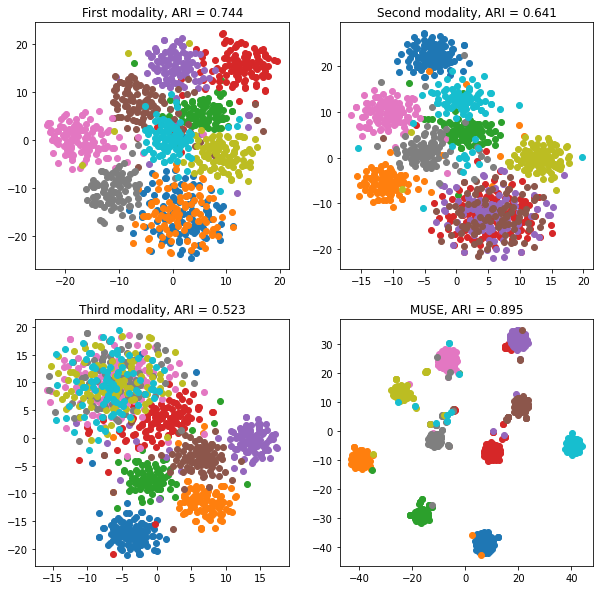

In [9]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
X_embedded = TSNE(n_components=2).fit_transform(view_a_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('First modality, ARI = %01.3f' % adjusted_rand_score(label_true, view_a_label))

plt.subplot(2, 2, 2)
X_embedded = TSNE(n_components=2).fit_transform(view_b_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Second modality, ARI = %01.3f' % adjusted_rand_score(label_true, view_b_label))

plt.subplot(2, 2, 3)
X_embedded = TSNE(n_components=2).fit_transform(view_c_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Third modality, ARI = %01.3f' % adjusted_rand_score(label_true, view_c_label))

plt.subplot(2, 2, 4)
X_embedded = TSNE(n_components=2).fit_transform(muse_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('MUSE, ARI = %01.3f' % adjusted_rand_score(label_true, muse_label))